# Tutorial: Use Great Expectations to validate Power BI datasets
This tutorial illustrates how to use SemPy together with [Great Expectations](https://greatexpectations.io/) (GX) to perform data validation on Power BI datasets.

### In this tutorial, you learn how to:
- Leverage Great Expectation's Fabric Data Source (built on semantic link) to validate constraints on datasets in your Fabric workspace. 
    - Configure a GX Data Context, Data Assets, and Expectations.
    - Run a GX Checkpoint to view validation results. 
- Use semantic link to analyze raw data.

### Prerequisites

* A [Microsoft Fabric subscription](https://learn.microsoft.com/fabric/enterprise/licenses). Or sign up for a free [Microsoft Fabric (Preview) trial](https://learn.microsoft.com/fabric/get-started/fabric-trial).
* Sign in to [Microsoft Fabric](https://fabric.microsoft.com/).
* Go to the Data Science experience in Microsoft Fabric.
* Select **Workspaces** from the left navigation pane to find and select your workspace. This workspace becomes your current workspace.
* Download the [_Retail Analysis Sample PBIX.pbix_](https://download.microsoft.com/download/9/6/D/96DDC2FF-2568-491D-AAFA-AFDD6F763AE3/Retail%20Analysis%20Sample%20PBIX.pbix) dataset and upload it to your workspace.
* Open your notebook. You have two options:
    * [Import this notebook into your workspace](https://learn.microsoft.com/en-us/fabric/data-engineering/how-to-use-notebook#import-existing-notebooks). You can import from the Data Science homepage.
    * Alternatively, you can create [a new notebook](https://learn.microsoft.com/fabric/data-engineering/how-to-use-notebook#create-notebooks) to copy/paste code into cells.

## Set up the notebook

In this section, you set up a notebook environment with the necessary modules and data.

1. Install `SemPy` and the relevant `Great Expectations` libraries from PyPI using the `%pip` in-line installation capability within the notebook.

In [1]:
# install libraries
%pip install semantic-link great-expectations great_expectations_experimental great_expectations_zipcode_expectations

# load %%dax cell magic
%load_ext sempy

StatementMeta(, 08d25d22-0b34-42cf-af42-326548d01c94, 8, Finished, Available)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.4/5.4 MB 96.6 MB/s eta 0:00:00ta 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 174.4/174.4 kB 75.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 125.2/125.2 kB 68.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 132.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 154.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.3/102.3 kB 51.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 801.0/801.0 kB 141.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 177.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 284.5/284.5 kB 86.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.3/51.3 kB 24.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.0/4.0 MB 151.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 395.8/395.8 kB 104.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━

2. Perform necessary imports of modules that you'll need later: 

In [2]:
import great_expectations as gx
from great_expectations.expectations.expectation import ExpectationConfiguration
from great_expectations_zipcode_expectations.expectations import expect_column_values_to_be_valid_zip5

StatementMeta(, 08d25d22-0b34-42cf-af42-326548d01c94, 10, Finished, Available)

/nfs4/pyenv-9fb1ecaa-9d79-40cb-a1d3-1aea8133675e/lib/python3.10/site-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')



## Set up GX Data Context and Data Source

In order to get started with Great Expectations, you first have to set up a GX [Data Context](https://docs.greatexpectations.io/docs/terms/data_context/). This serves as an entry point for GX operations and holds all relevant configurations.

In [3]:
context = gx.get_context()

StatementMeta(, 08d25d22-0b34-42cf-af42-326548d01c94, 11, Finished, Available)

Created temporary directory '/tmp/tmpq_662et6' for ephemeral docs site


You can then add your Fabric dataset to this context as a [Data Source](https://docs.greatexpectations.io/docs/terms/datasource) to start interacting with the data. This tutorial uses a standard Power BI sample dataset [Retail Analysis Sample PBIX](https://learn.microsoft.com/en-us/power-bi/create-reports/sample-retail-analysis).

In [4]:
ds = context.sources.add_fabric_powerbi("Retail Analysis Data Source", dataset="Retail Analysis Sample PBIX")

StatementMeta(, 08d25d22-0b34-42cf-af42-326548d01c94, 12, Finished, Available)

## Specify Data Assets

You can now define [Data Assets](https://docs.greatexpectations.io/docs/terms/data_asset) to define the subset of data you'd like to work with. These can be as simple as full tables, or be as complex as a custom DAX query.

##### Power BI Table

In [5]:
ds.add_powerbi_table_asset("Store Asset", table="Store")

StatementMeta(, 08d25d22-0b34-42cf-af42-326548d01c94, 13, Finished, Available)

PowerBITable(name='Store Asset', type='powerbi_table', id=None, order_by=[], batch_metadata={}, table='Store', fully_qualified_columns=False, num_rows=None, multiindex_hierarchies=False, pandas_convert_dtypes=True)

##### Power BI Measure
If your dataset contains preconfigured measures, you can add these as assets following a similar API to SemPy's `evaluate_measure`. 

In [6]:
ds.add_powerbi_measure_asset(
    "Total Units Asset",
    measure="TotalUnits",
    groupby_columns=["Time[FiscalYear]", "Time[FiscalMonth]"]
)

StatementMeta(, 08d25d22-0b34-42cf-af42-326548d01c94, 14, Finished, Available)

PowerBIMeasure(name='Total Units Asset', type='powerbi_measure', id=None, order_by=[], batch_metadata={}, measure='TotalUnits', groupby_columns=['Time[FiscalYear]', 'Time[FiscalMonth]'], filters=None, fully_qualified_columns=None, num_rows=None, pandas_convert_dtypes=True, use_xmla=False)

##### DAX
If you'd like to define your own measures or have more control over specific rows, you can add a DAX asset with a custom DAX query. Here, we define a `Total Units Ratio` measure by dividing two existing measures.

In [7]:
ds.add_powerbi_dax_asset(
    "Total Units YoY Asset",
    dax_string=
    """
    EVALUATE SUMMARIZECOLUMNS(
        'Time'[FiscalYear],
        'Time'[FiscalMonth],
        "Total Units Ratio", DIVIDE([Total Units This Year], [Total Units Last Year])
    )    
    """
)

StatementMeta(, 08d25d22-0b34-42cf-af42-326548d01c94, 15, Finished, Available)

PowerBIDax(name='Total Units YoY Asset', type='powerbi_dax', id=None, order_by=[], batch_metadata={}, dax_string='\n    EVALUATE SUMMARIZECOLUMNS(\n        \'Time\'[FiscalYear],\n        \'Time\'[FiscalMonth],\n        "Total Units Ratio", DIVIDE([Total Units This Year], [Total Units Last Year])\n    )    \n    ', pandas_convert_dtypes=True)

##### DMV Query
In some cases, it may be helpful to leverage [Dynamic Management View](https://learn.microsoft.com/en-us/analysis-services/instances/use-dynamic-management-views-dmvs-to-monitor-analysis-services?view=asallproducts-allversions) (DMV) calculations as part of the data validation process. For example, you can keep track of the number of referential integrity violations within your dataset. See "[Clean data = faster reports](https://dax.tips/2019/11/28/clean-data-faster-reports/)" for more information.

In [8]:
ds.add_powerbi_dax_asset(
    "Referential Integrity Violation",
    dax_string=
    """
    SELECT
        [Database_name],
        [Dimension_Name],
        [RIVIOLATION_COUNT]
    FROM $SYSTEM.DISCOVER_STORAGE_TABLES
    """
)

StatementMeta(, 08d25d22-0b34-42cf-af42-326548d01c94, 16, Finished, Available)

PowerBIDax(name='Referential Integrity Violation', type='powerbi_dax', id=None, order_by=[], batch_metadata={}, dax_string='\n    SELECT\n        [Database_name],\n        [Dimension_Name],\n        [RIVIOLATION_COUNT]\n    FROM $SYSTEM.DISCOVER_STORAGE_TABLES\n    ', pandas_convert_dtypes=True)

## Expectations

In order to add specific constraints to the assets defined above, you first have to configure [Expectation Suites](https://docs.greatexpectations.io/docs/terms/expectation_suite). After adding individual [Expectations](https://docs.greatexpectations.io/docs/terms/expectation) to each suite, you can then update the Data Context set up in the beginning with the new suite. For a full list of available expectations, see the [GX Expectation Gallery](https://greatexpectations.io/expectations/)

##### `Store` Table

In [9]:
suite_store = context.add_expectation_suite("Retail Store Suite")

suite_store.add_expectation(ExpectationConfiguration("expect_column_values_to_be_valid_zip5", { "column": "PostalCode" }))
suite_store.add_expectation(ExpectationConfiguration("expect_table_row_count_to_be_between", { "min_value": 80, "max_value": 200 }))

context.add_or_update_expectation_suite(expectation_suite=suite_store)

StatementMeta(, 08d25d22-0b34-42cf-af42-326548d01c94, 17, Finished, Available)

{
  "expectation_suite_name": "Retail Store Suite",
  "ge_cloud_id": null,
  "expectations": [
    {
      "expectation_type": "expect_column_values_to_be_valid_zip5",
      "kwargs": {
        "column": "PostalCode"
      },
      "meta": {}
    },
    {
      "expectation_type": "expect_table_row_count_to_be_between",
      "kwargs": {
        "min_value": 80,
        "max_value": 200
      },
      "meta": {}
    }
  ],
  "data_asset_type": null,
  "meta": {
    "great_expectations_version": "0.17.22"
  }
}

##### `TotalUnits` Measure

In [10]:
suite_measure = context.add_expectation_suite("Retail Measure Suite")
suite_measure.add_expectation(ExpectationConfiguration(
    "expect_column_values_to_be_between", 
    {
        "column": "TotalUnits",
        "min_value": 50000
    }
))

context.add_or_update_expectation_suite(expectation_suite=suite_measure)

StatementMeta(, 08d25d22-0b34-42cf-af42-326548d01c94, 18, Finished, Available)

{
  "expectation_suite_name": "Retail Measure Suite",
  "ge_cloud_id": null,
  "expectations": [
    {
      "expectation_type": "expect_column_values_to_be_between",
      "kwargs": {
        "column": "TotalUnits",
        "min_value": 50000
      },
      "meta": {}
    }
  ],
  "data_asset_type": null,
  "meta": {
    "great_expectations_version": "0.17.22"
  }
}

##### `Total Units Ratio` DAX

In [11]:
suite_dax = context.add_expectation_suite("Retail DAX Suite")
suite_dax.add_expectation(ExpectationConfiguration(
    "expect_column_values_to_be_between", 
    {
        "column": "[Total Units Ratio]",
        "min_value": 0.8,
        "max_value": 1.5
    }
))

context.add_or_update_expectation_suite(expectation_suite=suite_dax)

StatementMeta(, 08d25d22-0b34-42cf-af42-326548d01c94, 19, Finished, Available)

{
  "expectation_suite_name": "Retail DAX Suite",
  "ge_cloud_id": null,
  "expectations": [
    {
      "expectation_type": "expect_column_values_to_be_between",
      "kwargs": {
        "column": "[Total Units Ratio]",
        "min_value": 0.8,
        "max_value": 1.5
      },
      "meta": {}
    }
  ],
  "data_asset_type": null,
  "meta": {
    "great_expectations_version": "0.17.22"
  }
}

##### Referential Integrity Violations (DMV)

In [12]:
suite_dmv = context.add_expectation_suite("Retail DMV Suite")
# There should be no RI violations
suite_dmv.add_expectation(ExpectationConfiguration(
    "expect_column_values_to_be_in_set", 
    {
        "column": "RIVIOLATION_COUNT",
        "value_set": [0]
    }
))
context.add_or_update_expectation_suite(expectation_suite=suite_dmv)

StatementMeta(, 08d25d22-0b34-42cf-af42-326548d01c94, 20, Finished, Available)

{
  "expectation_suite_name": "Retail DMV Suite",
  "ge_cloud_id": null,
  "expectations": [
    {
      "expectation_type": "expect_column_values_to_be_in_set",
      "kwargs": {
        "column": "RIVIOLATION_COUNT",
        "value_set": [
          0
        ]
      },
      "meta": {}
    }
  ],
  "data_asset_type": null,
  "meta": {
    "great_expectations_version": "0.17.22"
  }
}

## Validation

To actually run the specified expectations against the data, you need to create a [Checkpoint](https://docs.greatexpectations.io/docs/terms/checkpoint) and add it to the context. For more information on Checkpoint configuration, see [Data Validation workflow](https://docs.greatexpectations.io/docs/guides/validation/validate_data_overview).

In [13]:
checkpoint_config = {
    "name": f"Retail Analysis Checkpoint",
    "validations": [
        {
            "expectation_suite_name": "Retail Store Suite",
            "batch_request": {
                "datasource_name": "Retail Analysis Data Source",
                "data_asset_name": "Store Asset",
            },
        },
        {
            "expectation_suite_name": "Retail Measure Suite",
            "batch_request": {
                "datasource_name": "Retail Analysis Data Source",
                "data_asset_name": "Total Units Asset",
            },
        },
        {
            "expectation_suite_name": "Retail DAX Suite",
            "batch_request": {
                "datasource_name": "Retail Analysis Data Source",
                "data_asset_name": "Total Units YoY Asset",
            },
        },
        {
            "expectation_suite_name": "Retail DMV Suite",
            "batch_request": {
                "datasource_name": "Retail Analysis Data Source",
                "data_asset_name": "Referential Integrity Violation",
            },
        },
    ],
}
checkpoint = context.add_checkpoint(
    **checkpoint_config
)

StatementMeta(, 08d25d22-0b34-42cf-af42-326548d01c94, 21, Finished, Available)

You can now run the checkpoint and extract the results as a pandas DataFrame for simple formatting.

In [14]:
result = checkpoint.run()

StatementMeta(, 08d25d22-0b34-42cf-af42-326548d01c94, 22, Finished, Available)

<frozen importlib._bootstrap>:283: DeprecationWarning: the load_module() method is deprecated and slated for removal in Python 3.12; use exec_module() instead

<frozen importlib._bootstrap>:283: DeprecationWarning: the load_module() method is deprecated and slated for removal in Python 3.12; use exec_module() instead

/home/trusted-service-user/cluster-env/trident_env/lib/python3.10/site-packages/ipykernel/comm/comm.py:79: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  warn(



Calculating Metrics:   0%|          | 0/10 [00:00<?, ?it/s]

/home/trusted-service-user/cluster-env/trident_env/lib/python3.10/site-packages/ipykernel/comm/comm.py:79: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  warn(



Calculating Metrics:   0%|          | 0/10 [00:00<?, ?it/s]

/home/trusted-service-user/cluster-env/trident_env/lib/python3.10/site-packages/ipykernel/comm/comm.py:79: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  warn(



Calculating Metrics:   0%|          | 0/10 [00:00<?, ?it/s]

/home/trusted-service-user/cluster-env/trident_env/lib/python3.10/site-packages/ipykernel/comm/comm.py:79: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  warn(



Calculating Metrics:   0%|          | 0/10 [00:00<?, ?it/s]

StatementMeta(, 08d25d22-0b34-42cf-af42-326548d01c94, 30, Finished, Available)

In [15]:
import pandas as pd

data = []

for run_result in result.run_results:
    for validation_result in result.run_results[run_result]["validation_result"]["results"]:
        row = {
            "Batch ID": run_result.batch_identifier,
            "type": validation_result.expectation_config.expectation_type,
            "success": validation_result.success
        }

        row.update(dict(validation_result.result))
        
        data.append(row)

result_df = pd.DataFrame.from_records(data)    

result_df[["Batch ID", "type", "success", "element_count", "unexpected_count", "partial_unexpected_list"]]

StatementMeta(, 08d25d22-0b34-42cf-af42-326548d01c94, 23, Finished, Available)

<frozen importlib._bootstrap>:283: DeprecationWarning: the load_module() method is deprecated and slated for removal in Python 3.12; use exec_module() instead

<frozen importlib._bootstrap>:283: DeprecationWarning: the load_module() method is deprecated and slated for removal in Python 3.12; use exec_module() instead



,Batch ID,type,success,element_count,unexpected_count,partial_unexpected_list
0,Retail Analysis Data Source-Store Asset,expect_column_values_to_be_valid_zip5,True,104.0,0.0,[]
1,Retail Analysis Data Source-Store Asset,expect_table_row_count_to_be_between,True,NaN,NaN,NaN
2,Retail Analysis Data Source-Total Units Asset,expect_column_values_to_be_between,True,8.0,0.0,[]
3,Retail Analysis Data Source-Total Units YoY Asset,expect_column_values_to_be_between,False,8.0,3.0,"[0.7972605895837893, 0.7302630613281353, 0.663..."
4,Retail Analysis Data Source-Referential Integr...,expect_column_values_to_be_in_set,True,84.0,0.0,[]


From these results we can see that all our our expectations have passed the validation, except for the "Total Units YoY Asset" that we defined through a custom DAX query. 

## Diagnostics

Using semantic link, you can fetch the source data to understand which exact years are out of range. Semantic link provides an inline magic for executing DAX queries, which we can use to execute the same query we passed into the GX Data Asset and visualize the resulting values.

In [16]:
%%dax "Retail Analysis Sample PBIX"

EVALUATE SUMMARIZECOLUMNS(
    'Time'[FiscalYear],
    'Time'[FiscalMonth],
    "Total Units Ratio", DIVIDE([Total Units This Year], [Total Units Last Year])
)

StatementMeta(, 08d25d22-0b34-42cf-af42-326548d01c94, 24, Finished, Available)

,Time[FiscalYear],Time[FiscalMonth],[Total Units Ratio]
0,2014,Jan,0.797261
1,2014,Feb,0.95912
2,2014,Mar,1.282908
3,2014,Apr,0.730263
4,2014,May,1.084064
5,2014,Jun,0.969717
6,2014,Jul,0.663352
7,2014,Aug,0.810861


In [17]:
df = _

StatementMeta(, 08d25d22-0b34-42cf-af42-326548d01c94, 25, Finished, Available)

StatementMeta(, 08d25d22-0b34-42cf-af42-326548d01c94, 26, Finished, Available)

<frozen importlib._bootstrap>:283: DeprecationWarning: the load_module() method is deprecated and slated for removal in Python 3.12; use exec_module() instead



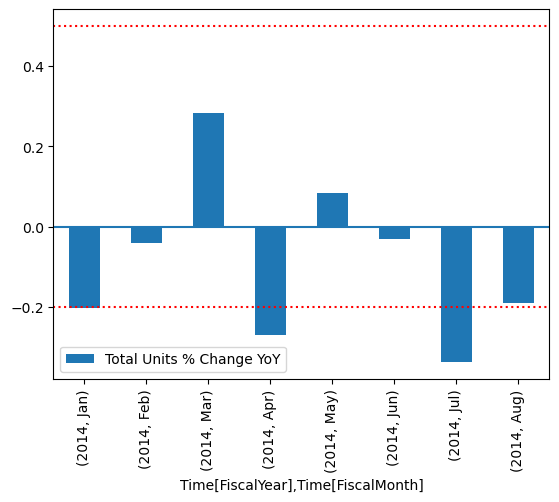

In [18]:
import matplotlib.pyplot as plt

df["Total Units % Change YoY"] = (df["[Total Units Ratio]"] - 1)

df.set_index(["Time[FiscalYear]", "Time[FiscalMonth]"]).plot.bar(y="Total Units % Change YoY")

plt.axhline(0)

plt.axhline(-0.2, color="red", linestyle="dotted")
plt.axhline( 0.5, color="red", linestyle="dotted")

None

From this, we can see that April and July were slightly out of range and can then take further steps to investigate.

## Storing GX Configuration

As the data in your dataset changes over time, you may want to rerun the GX validations you just performed. Currently, the Data Context (containing the connected Data Assets, Expectation Suites, and Checkpoint) lives ephemerally, but it can be converted to a File Context for future use. Alternatively, the conext could have been instatiated as a File Conext (see [Instantiate a Data Context](https://docs.greatexpectations.io/docs/guides/setup/configuring_data_contexts/instantiating_data_contexts/instantiate_data_context#specify-a-folder-containing-a-previously-initialized-filesystem-data-context))

In [19]:
context = context.convert_to_file_context()

StatementMeta(, 08d25d22-0b34-42cf-af42-326548d01c94, 27, Finished, Available)

Successfully migrated to FileDataContext!


In [20]:
# copy GX directory to attached lakehouse
!cp -r gx/ /lakehouse/default/Files/gx

StatementMeta(, 08d25d22-0b34-42cf-af42-326548d01c94, 28, Finished, Available)

Now, future contexts can be created with `context = gx.get_context(project_root_dir="<your path here>")` and will contain all the configurations from above.